<a href="https://colab.research.google.com/github/pszwed-ai/lab-eksploracja-danych/blob/main/NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naiwny klasyfikator Bayesa (Naive Bayes)

## 1. NB z rozkładem Gaussa: przygotowania 

Ładujemy dane do eksperymentów


In [36]:
import numpy as np
from io import StringIO

data = """
-3,2,0
-3,-1,0
-2,0.8,0
-1.3,0.6,0
0,3,0
0,-1,0
.75,2.7,0
2,3.8,0
-2.8,-3.1,0
-2.2,-3,1
-1.1,-.5,1
-0.7,-.2,1
0.2,-2.1,1
1.4,2,1
1.1,-2.2,1
1.9,0,1
2.2,2.9,1
"""


inp =  StringIO(data)
x1, x2, y = np.loadtxt(inp, delimiter=',', usecols=(0, 1,2), unpack=True,skiprows=0)
X = np.stack((x1,x2),axis=-1)


### 1.1 Parametry modelu

Obliczamy:
* Prawdopodobieństwo *a-priori* wystąpienia klas (ang. priors)
* Średnie wartości atrybutów ```mu0``` i ```mu1``` dla obu klas
* Wariancje atrybutów ```sigma1``` i ```sigma2``` dla obu klas 

In [37]:
X0=X[y==0]
X1=X[y==1]

prior0=X0.shape[0]/X.shape[0]
prior1=X1.shape[0]/X.shape[0]
print(f'prior0={prior0} prior1={prior1}')

mu0=X0.mean(axis=0)
mu1=X1.mean(axis=0)

sigma0=X0.std(axis=0)**2
sigma1=X1.std(axis=0)**2

print(f'mu0={mu0} sigma0={sigma0}\nmu1={mu1} sigma1={sigma1}')




prior0=0.5294117647058824 prior1=0.47058823529411764
mu0=[-1.03888889  0.86666667] sigma0=[2.93098765 4.50888889]
mu1=[ 0.35   -0.3875] sigma1=[2.1525     3.71859375]


Wyznacz $p(x|y=0)$. 

Klasa ```multivariate_normal``` pozwala na obliczenie gęstości prawdopodobieństwa w punkcie $x\in R^n$. Tworząc obiekt klasy podajemy:
* wektor średnich wartości
* macierz kowariancji - która w tym przypadku jets macierzą diagonalną ```np.diag(sigma?)```  

In [38]:
from scipy.stats import multivariate_normal
print(X.shape)
rv0 = multivariate_normal(mu0,np.diag(sigma0))
rv0.pdf(X)

(17, 2)


array([0.01970087, 0.01543597, 0.03737902, 0.04293411, 0.02198552,
       0.02474612, 0.01747114, 0.00348908, 0.00450536, 0.00662756,
       0.03556722, 0.03784205, 0.01269717, 0.01376381, 0.00707012,
       0.00923024, 0.00462344])

Aleternatywą jest obliczenie prawdopodobieństawa dla każdego wymiaru z osobna z użyciem klasy ```norm```.

**TODO**
* Oblicz prawdopodobieństwo dla X0 wyznaczając prawdopodobienstwa dla wymiarów 0 i 1, a następnie mnożąc je przez siebie. 

In [39]:
from scipy.stats import norm

# zwraca wartość średnią i odchylenie standardowe 
n00=norm.fit(X0[:,0])
n01=???

p1=norm.pdf(X0[:,0],n00[0],n00[1])
p2=???
p=p1*p2
print(p)


[0.01970087 0.01543597 0.03737902 0.04293411 0.02198552 0.02474612
 0.01747114 0.00348908 0.00450536]


### 1.2 Bayes i predykcja

Zastosuj twierdzenie Bayesa do wyznaczenia

$p(y=0|x)=\frac{p(x|y=0)\cdot p(y=0)}{p(x)}$

Oblicz $p(x)$ jako prawdopodobieństwo całkowite: 

$p(x)=p(x|y=0)\cdot p(y=0) + p(x|y=1)\cdot p(y=1)$

Do wyznaczenia prawdopodobieństwa w $R^2$ użyj klasy  ```multivariate_normal```

In [16]:
# prawdopodobieństwa

from scipy.stats import multivariate_normal

def prob_class_given_x(x):
  rv0 = multivariate_normal(mu0,np.diag(sigma0))
  rv1 = multivariate_normal(mu1,np.diag(sigma1))
  px = rv0.pdf(x)*prior0 + rv1.pdf(x)*prior1
  pc_x0 = rv0.pdf(x)*prior0/px
  # print(pc_x0)
  pc_x1 = rv1.pdf(x)*prior1/px
  return np.stack([pc_x0,pc_x1],axis=-1),px

pcx, px = prob_class_given_x(X)

print(pcx)
print(px)


[[0.91996325 0.08003675]
 [0.8148577  0.1851423 ]
 [0.76520331 0.23479669]
 [0.64818768 0.35181232]
 [0.67910782 0.32089218]
 [0.34874958 0.65125042]
 [0.56644581 0.43355419]
 [0.58119994 0.41880006]
 [0.70834197 0.29165803]
 [0.60043755 0.39956245]
 [0.53728173 0.46271827]
 [0.49553467 0.50446533]
 [0.27464562 0.72535438]
 [0.43351425 0.56648575]
 [0.20039176 0.79960824]
 [0.24761737 0.75238263]
 [0.4668557  0.5331443 ]]
[0.01133727 0.01002872 0.02586096 0.03506673 0.01713924 0.03756531
 0.01632888 0.00317818 0.00336729 0.00584358 0.03504624 0.04042911
 0.02447528 0.0168085  0.01867844 0.01973447 0.00524295]


Wyznaczamy etykietę klasy wybierając jako etykietę klasy tę, której odpowiada największe prawdopodobieństwo.

In [ ]:
#classify
y_pred = np.argmax(pcx,axis=1)
print(y_pred)

#porównajmy
print(np.stack( (y,y_pred) ))

[0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]]


### 1.3 Rysunek

Definiujemy funkcję do rysowania. Jej parametrem są:
* ```funkcja_2D``` - funkcja $R^2 \to R$ służąca do predykcji 
* wymiary obszaru 2D
* inne dane: mapa kolorów, opcja wypełnienia

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"] = (12,8)


def plot_mesh(function_2d,x_min,x_max,y_min,y_max,h=0.01,cm=None,fill=False):
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = function_2d(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  if cm is None:
    cm = plt.cm.RdBu_r
  if fill:
    plt.pcolormesh(xx, yy, Z, cmap=cm)
  plt.contour(xx, yy, Z, 21, cmap=cm)



**TODO**
* Narysuj $p(x|y==0)$ i $p(x|y==1)$ - czyli do funkcji ```plot_mesh``` przekaż funkcję obliczającą pdf dla wyznaczonych rozkładów normalnych ```rv0``` i ```rv1```. 

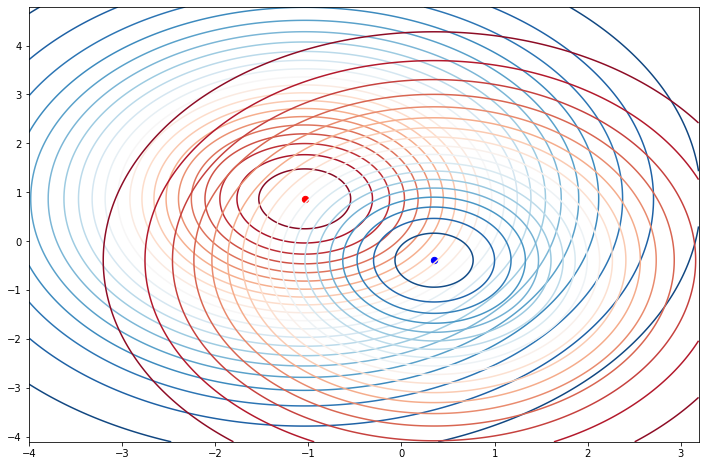

In [14]:
#plot 

rv0 = multivariate_normal(mu0,np.diag(sigma0))
rv1 = multivariate_normal(mu1,np.diag(sigma1))

plot_mesh( ??? ,X[:,0].min()-1,X[:,0].max()+1,X[:,1].min()-1,X[:,1].max()+1,cm = plt.cm.RdBu_r)
plot_mesh( ??? ,X[:,0].min()-1,X[:,0].max()+1,X[:,1].min()-1,X[:,1].max()+1,cm = plt.cm.RdBu)
# narysuj wartości średnie (maksimum pdf)
plt.scatter(mu0[0], mu0[1], c='r', marker='o',edgecolors='Face', s=40)
plt.scatter(mu1[0], mu1[1], c='b', marker='o',edgecolors='Face', s=40)

plt.show()

**TODO**
* Narysuj wykres prawdopodobieństawa pierwszej klasy i nanieś punkty.

In [17]:
def prob_first_class(X):
  pcx, px = prob_class_given_x(X)
  return pcx[????]

prob_first_class(X)


array([0.91996325, 0.8148577 , 0.76520331, 0.64818768, 0.67910782,
       0.34874958, 0.56644581, 0.58119994, 0.70834197, 0.60043755,
       0.53728173, 0.49553467, 0.27464562, 0.43351425, 0.20039176,
       0.24761737, 0.4668557 ])

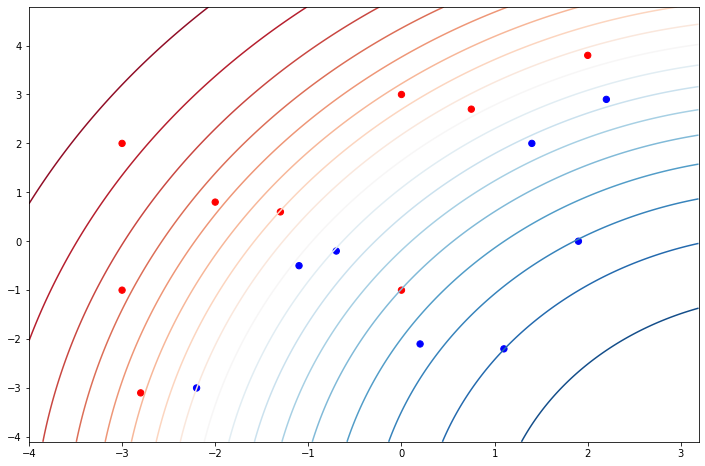

In [ ]:
plot_mesh(prob_first_class,X[:,0].min()-1,X[:,0].max()+1,X[:,1].min()-1,X[:,1].max()+1,cm = plt.cm.RdBu_r)
cm = ListedColormap(['r', 'b'])
plt.scatter(x1, x2, c=y, marker='o',edgecolors='Face', s=40,cmap=cm)
plt.show()


**TODO**
* Analogicznie wygeneruj rysunek prawdopodobieństwa dla drugiej klasy. Czy te wykresy są różne? (W kodzie została odwrócona mapa kolorów do rysowania poziomic.)

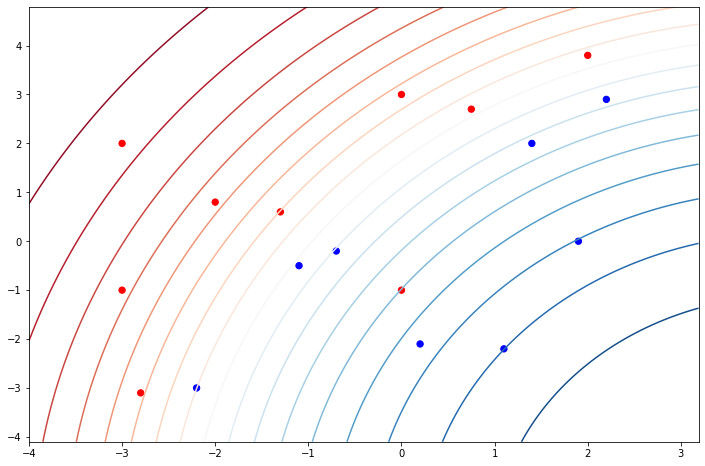

In [19]:
def prob_second_class(X):
  pcx, px = prob_class_given_x(X)
  # print(f'pcx.shape={pcx.shape}')
  return pcx[???]

plot_mesh(prob_second_class,X[:,0].min()-1,X[:,0].max()+1,X[:,1].min()-1,X[:,1].max()+1,cm = plt.cm.RdBu)
cm = ListedColormap(['r', 'b'])
plt.scatter(x1, x2, c=y, marker='o',edgecolors='Face', s=40,cmap=cm)
plt.show()


### 1.4 Obliczenia w skali logarytmicznej

* Obliczamy ```logpdf``` zamiast ```pdf```
* Pomijamy $p(x)$  w mianowniku, zamiast tego prawdopodobieństwa będą skalowane 
* Podczas obliczeń w skali logarytmicznej mnożenie zamienia się na dodawanie, a dzielenie na odejmowanie

**TODO**
* Sprawdż, czy rzeczywiście prawdopodobieństwa sumują się do 1



In [23]:
from scipy.special import logsumexp

def log_prob_class_given_x(x):
  rv0 = multivariate_normal(mu0,np.diag(sigma0))
  rv1 = multivariate_normal(mu1,np.diag(sigma1))
  pc_x0 = rv0.logpdf(x) + np.log(prior0)
  pc_x1 = rv1.logpdf(x) + np.log(prior1)
  logprob=np.stack((pc_x0,pc_x1),axis=-1)
  # print(logprob.shape)
  divby=logsumexp(logprob,axis=-1,keepdims=True)
  # print(divby.shape)

  # dzielenie przez liczbę dla logarytmów to ... 
  logprob=logprob-divby
  return logprob

print("Tablica logarytmów prawdopodobieństw")
print(log_prob_class_given_x(X))
print("Tablica sum prawdopodobieństw")
????


Tablica logarytmów prawdopodobieństw
[[-0.08342156 -2.52526936]
 [-0.20474178 -1.68663057]
 [-0.26761372 -1.44903529]
 [-0.43357499 -1.04465744]
 [-0.38697538 -1.13665009]
 [-1.05340115 -0.42886104]
 [-0.56837386 -0.83573849]
 [-0.54266045 -0.87036165]
 [-0.34482829 -1.2321733 ]
 [-0.51009665 -0.91738519]
 [-0.62123268 -0.77063691]
 [-0.70211797 -0.68425615]
 [-1.29227366 -0.32109495]
 [-0.8358306  -0.56830336]
 [-1.607481   -0.22363338]
 [-1.39587061 -0.28451026]
 [-0.76173506 -0.62896316]]
Tablica sum prawdopodobieństw


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Znajdź informacje o funkcji LogSumExp, np. https://en.wikipedia.org/wiki/LogSumExp (oraz bliskiej jej funkcji *softmax*)

**TODO**
* Co wyznaczamy za pomocą tej funkcji?

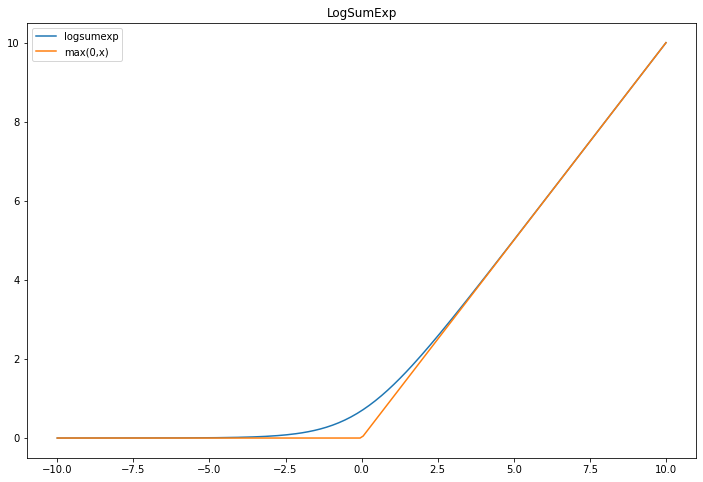

In [ ]:
tx = np.linspace(-10,10,200)
ty = logsumexp(np.stack((tx,tx*0),axis=-1),axis=-1)
plt.plot(tx,ty,label='logsumexp')
relu=np.where(tx<0,0,tx)
plt.plot(tx,relu,label='max(0,x)')
plt.title('LogSumExp')
plt.legend()
plt.show()

### 1.5 Jeszcze raz rysujemy

**TODO**
* Czy można wyjaśnić, dlaczego największe prawdopodobieństwo $p(blue|x)$ nie pokrywa się ze średnią $\mu_{blue}$

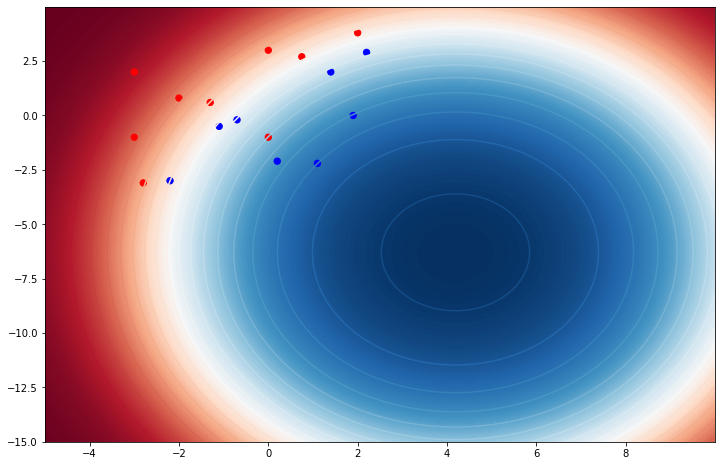

In [ ]:
def prob_first_class2(x):
  logprob = log_prob_class_given_x(x)
  # print(f'logprob.shape={logprob.shape}')
  return np.exp(logprob)[...,0]

plot_mesh(prob_first_class2,-5,10,-15,5,cm = plt.cm.RdBu_r,fill=True)
cm = ListedColormap(['r', 'b'])
plt.scatter(x1, x2, c=y, marker='o',edgecolors='Face', s=40,cmap=cm)
plt.show()

## 2. Klasyfikator MyGaussianNaiveBayesClassifier

Piszemy własny klasyfikator z interfejsem dopasownaym do klasyfiaktorów z biblioteki ```sklearn```.

### 2.1 Implementacja

* Funkcja ```fit(X,y)``` buduje model. Niech ```n_classes``` będzie liczbą klas.
  Każda klasa opisana jest przez
  * Wektor means o rozmiarze ```X.shape[1]```
  * Wektor sigmas o rozmiarze ```X.shape[1]```
  Prawdopodobieństwa apriori są zebrane w postaci wektora ```priors``` o rozmiatrze ```n_classes```
* Funkcja ```predict_log_proba(X)``` zwraca logartym prawdopodobieństwa przypisywanego klasom dla kolejnych obserwacji w wierszach.

**TODO**
* Zaimplementuj ```predict_proba(X)``` wywołując ```predict_log_proba(X)```
* Zaimplementuj ```predict(X)``` korzystając z ```np.argmax()```

In [25]:
import numpy as np
from sklearn.base import BaseEstimator
from scipy.stats import multivariate_normal

class MyGaussianNaiveBayesClassifier(BaseEstimator):
  
  def __init__(self):
    pass
  
  def fit(self,X,y):
    """Buduje model klasyfikatora"""
    # ile etykiet?
    y=y.astype(np.int)
    self.n_classes = y.max()+1
    # wyznacz tablice średnich i wariancji dla poszczególnych klas
    self.means=[ X[y==i].mean(axis=0) for i in range(self.n_classes)]
    self.sigmas=[X[y==i].std(axis=0)**2 for i in range(self.n_classes)]
    # print(self.sigmas)
    # wyznacza prawdopodobieństwa apriori dla klas
    self.priors=[ np.count_nonzero(y == i)/y.shape[0] for i in range(self.n_classes)]
    
  def predict_log_proba(self,X):
    """Zwarca macierz logarytmów prawdopodobieństw o wymiarach n_classes x X.shape[0]""" 
    logprob=[]
  
    for i in range(self.n_classes):
      # dla każdej klasy oblicz p(x|y==i)*p(y==i) w skali logarytmicznej
      # wynik dodaj 
      rv = multivariate_normal(self.means[i],np.diag(self.sigmas[i]))
      log_p = rv.logpdf(X)+np.log(self.priors[i])
      logprob.append(log_p)
    logprob=np.stack(logprob,axis=-1)
    # print(logprob.shape)
    divby=logsumexp(logprob,axis=-1,keepdims=True)
    # print(divby.shape)
    logprob=logprob-divby
    return logprob

  def predict_proba(self,X):
    """Zwarca macierz prawdopodobieństw o wymiarach n_classes x X.shape[0]""" 
    return ???

  def predict(self,X):
    """Zwarca jednowymiarowa tablicę etykiet klas o wymiarch X.shape[0].
    Wybiera klasę o największym prawdopodobieństwie""" 
    return ???
    

### 2.2 Test klasyfikatora

In [26]:
#test

cls = MyGaussianNaiveBayesClassifier()
print(X)
print(y)
cls.fit(X,y)
y_pred = cls.predict(X)
print(y_pred)

acc = np.where(y==y_pred,1,0).sum()/y.shape[0]
print(f'accuracy={acc}')


[[-3.    2.  ]
 [-3.   -1.  ]
 [-2.    0.8 ]
 [-1.3   0.6 ]
 [ 0.    3.  ]
 [ 0.   -1.  ]
 [ 0.75  2.7 ]
 [ 2.    3.8 ]
 [-2.8  -3.1 ]
 [-2.2  -3.  ]
 [-1.1  -0.5 ]
 [-0.7  -0.2 ]
 [ 0.2  -2.1 ]
 [ 1.4   2.  ]
 [ 1.1  -2.2 ]
 [ 1.9   0.  ]
 [ 2.2   2.9 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1]
accuracy=0.8235294117647058


### 2.3 Wyświetlamy regiony decyzyjne

* Jeżeli pomijamy prawdopodobieństwa - przekazujemy do plot_mesh funkcję/obiekt funkcyjny ```cls.predict```. 
* Jeżeli chcemy zwizualizować prawdopodobienstwa, powinniśmy przekazać to funkcję, która dla argumentu ```X``` woła ```cls.predict_proba(X)```, a następnie zwraca jedną z kolumn wyniku.



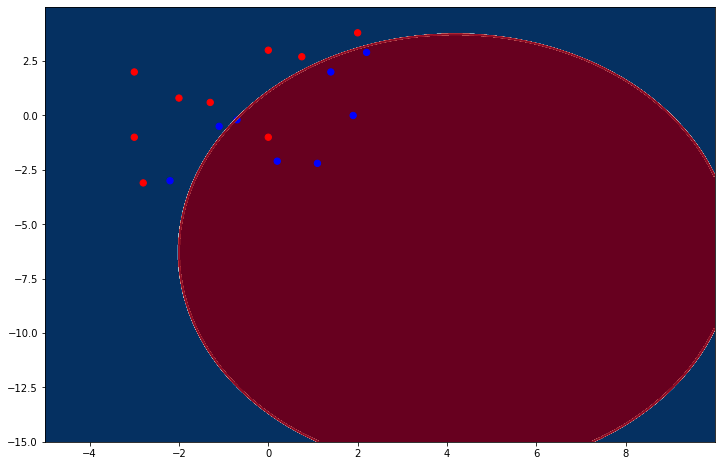

In [27]:

plot_mesh(cls.predict,-5,10,-15,5,cm = plt.cm.RdBu_r,fill=True)
cm = ListedColormap(['r', 'b'])
plt.scatter(x1, x2, c=y, marker='o',edgecolors='Face', s=40,cmap=cm)
plt.show()

**TODO** 
* Napisz i przekaż funkcję, która woła predict_proba(X) i zwraca pierwszą kolumnę wyniku (czyli wynik[:,0]). Możesz to na przykład zrealizować, jako wyrażenie lambda.

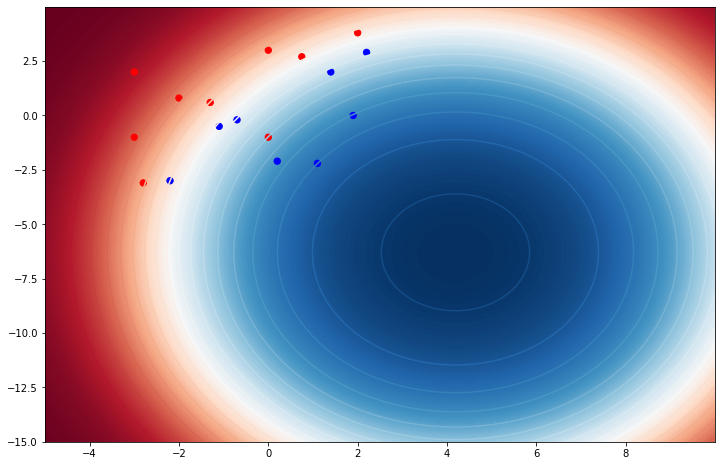

In [ ]:
plot_mesh(????,-5,10,-15,5,cm = plt.cm.RdBu_r,fill=True)
cm = ListedColormap(['r', 'b'])
plt.scatter(x1, x2, c=y, marker='o',edgecolors='Face', s=40,cmap=cm)
plt.show()

### 2.4 Testujemy na zbiorze Iris

**TODO**
* oblicz accuracy i f1 (macro)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
cls = MyGaussianNaiveBayesClassifier()
# cls = GaussianNB()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score


acc = ???
f1 = ???

print(f'acc={acc} f1={f1}')



acc=0.9555555555555556 f1=0.9488636363636364


### 2.5 Wydruk regionów decyzyjnych w 2D 

Rysowane są regiony decyzyjne i punkty dla dwóch pierwszych współrzędnych. 
Podczas predykcji siatki punktów dla regionów decyzyjnych sa ustawiane te same wartości współrzednych 2 i 3.

m2=2.5 m3=0.4


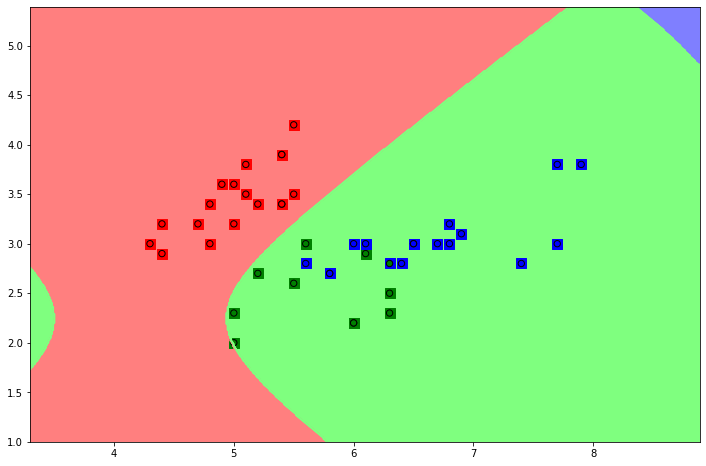

In [ ]:
class predictor_wrapper:
  def __init__(self,predictor,x2,x3):
    self.predictor = predictor
    self.x2=x2
    self.x3=x3
  def __call__(self,X):
    X23=np.ones((X.shape[0],2))
    X23[:,0]*=self.x2
    X23[:,1]*=self.x3
    X0123 = np.hstack((X,X23))
    return self.predictor.predict(X0123)


m2=2.5
m3=0.40

print(f'm2={m2} m3={m3}')
plt.figure()
cm = ListedColormap(['#ff7f7f', '#7fff7f', '#7f7fff'])
plot_mesh(predictor_wrapper(cls,m2,m3),X[:,0].min()-1, X[:,0].max()+1, X[:,1].min()-1,X[:,1].max()+1,cm = cm,fill=True)

cm = ListedColormap(['r', 'g', 'b'])
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='s',edgecolors='Face', s=100,cmap=cm)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker='o',edgecolors='k', s=40,cmap=cm)

plt.show()


## Multinomial

Multininomial NB różni się zastosowanym rozkładem. https://en.wikipedia.org/wiki/Multinomial_distribution

Jeżeli mamy wektor prawdopodobieństw $[0.2, 0.3,0.1, 0.4]$ to pawdopodobieństwo wystąpienia danych $x=[1,0,2,4]$ wynosi $p(x)=\frac{7!}{1!\cdot 0!\cdot 2! \cdot 4!}\cdot 0.2^1 \cdot 0.3^0 \cdot 0.1^2\cdot 0.4^4$. Przenosimy to także na sytuację, kiedy dane $x$ zostały wyskalowane (nie są liczbami całkowitymi).

Czyli wynikowe prawdopodobieństwo wynosi: 

$p(x)=C(x)\prod_{i=1,n}p_i^{x_i}$., gdzie $C(x)$ wyłącznie zależy od $x$ - jest odpowiednikiem $\frac{n!}{x_1!\dots x_n!}$

Logarytmując otrzymujemy: 

$log(p(x))=\sum_{i=1,n}x_i\cdot log(p_i) + log(C(x))$                    

Aby obliczyć $log(p(x))$ wyznaczamy iloczyn skalarny wektora $x$ i wektora $log(p_i)$. Przy porównaniach prawdopodobieństw klas składnik $log(C(x))$ można pominąć, ponieważ, zależy wyłącznie od obserwacji i pojawi się bez zmian w równaniach dla każdej z klas.  






### Implementacja

Modelem są komponenty:
* n_classes
* log_likehoods o rozmiarze n_classes x X.shape[1]
* log_priors o rozmiarze n_classes (wektor prawdopodobieństw apriori)

**TODO** 
* W funkcji ```predict_log_proba(X)```oblicz dla każdej klasy log_p. Jak wcześniej stwierdzono - ma to być iloczyn skalarny prawdopodobieństw log_likehood i wierszy X  skorygowany o log_priors.  

In [30]:
import numpy as np
from sklearn.base import BaseEstimator
from scipy.special import logsumexp

class MyMultinomialNaiveBayesClassifier(BaseEstimator):
  
  def __init__(self,alpha=1):
    self.alpha = alpha
  
  def fit(self,X,y):
    # ile etykiet?
    y=y.astype(np.int)
    self.n_classes = y.max()+1
    minx = X.min()
    if minx < 0:
      raise ValueError('Expected non-negative values')
    X=X.copy()
    X+=self.alpha/X.shape[1]
    self.log_likelihoods = [ np.log(X[y==i].sum(axis=0)) - np.log(X[y==i].sum()) for i in range(self.n_classes)]
    for ll in self.log_likelihoods:
      ll.reshape((X.shape[1],1))
    self.log_priors = [ np.log(np.count_nonzero(y == i)/y.shape[0]) for i in range(self.n_classes)]

  def predict_log_proba(self,X):
    logprob=[]
    for i in range(self.n_classes):
      log_p = ??? uzyj X self.log_likelihoods[i]) oraz self.log_priors[i]
      logprob.append(log_p)
    logprob=np.stack(logprob,axis=-1)
    # print(logprob.shape)
    divby=logsumexp(logprob,axis=-1,keepdims=True)
    # print(divby.shape)
    logprob=logprob-divby
    return logprob

  def predict_proba(self,X):
    return np.exp(self.predict_log_proba(X))

  def predict(self,X):
    return np.argmax(self.predict_log_proba(X),axis=1)
    

### Test klasyfikatora

**TODO**
* Proszę porównać wyniki z biblioteczną wersją ```MultinomialNB```. Powinny być podobne...

In [35]:
# from sklearn.datasets import load_wine
from sklearn.datasets import load_digits

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# X,y = load_wine(return_X_y=True)
X,y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
cls = MyMultinomialNaiveBayesClassifier()

# cls = MultinomialNB()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score


acc = accuracy_score(y_pred,y_test)
f1 = f1_score(y_pred,y_test,average='macro')

print(f'acc={acc} f1={f1}')


acc=0.8870370370370371 f1=0.8862236271368233
